# Train cycleGAN

Scripts to train cycleGAN were adopted from the [cycleGAN repository](https://github.com/eriklindernoren/PyTorch-GAN#cyclegan) that were based on the [Unpaired Image-to-Image Translation using Cycle-Consistent Adversarial Networks](https://arxiv.org/pdf/1703.10593.pdf) paper.

The scripts were modified to:
1. Use fully connected networks as opposed to convoultional neural networks
2. Input gene expression data as opposed to image data

In [94]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import os
import pandas as pd
import numpy as np
import random
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import pearsonr, spearmanr
from numpy.random import seed
import umap
from sklearn.manifold import TSNE

randomState = 123
seed(randomState)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Train Step 1

In [236]:
exp_index = 6
num_samples = 50000
data_version = "v2"


In [237]:
!python functions/delete.py --exp_index $exp_index

In [238]:
!python functions/cyclegan_transcript.py --dataset_nameA "L1000" --dataset_nameB "ARCHS4" --n_epochs 100 --decay_epoch 50 --input_dimA 962 --hidden_dimA 512 --output_dimA 128 --input_dimB 962 --hidden_dimB 512 --output_dimB 128   --num_samples $num_samples --batch_size 100 --exp_index $exp_index --data_version $data_version

Namespace(b1=0.9, b2=0.999, batch_size=100, cell_line=None, checkpoint_interval=10, data_version='v2', dataset_nameA='L1000', dataset_nameB='ARCHS4', decay_epoch=50, epoch_resume=0, eval_dataset_nameA='GTEx', eval_dataset_nameB='GTEx', exp_index=6, gamma=0.1, hidden_dimA=512, hidden_dimB=512, input_dimA=962, input_dimB=962, ispredicting=False, lambda_cyc=10.0, lambda_id=5.0, load_model_index=100, lr=0.0002, n_cpu=8, n_epochs=100, n_residual_blocks=1, num_samples=50000, output_dimA=128, output_dimB=128, sample_interval=100, shuffle=False)
Cuda available True
                                 AARS     ABCB6  ...    ZNF589      ZW10
/meta/samples/geo_accession                      ...                    
GSM2889090                   3.578353  2.445790  ...  1.974877  1.860441
GSM1341737                   2.310967  1.642320  ...  2.013800  2.378100
GSM2127901                   3.231217  2.007936  ...  3.060763  2.504226
GSM3387238                   3.284476  2.109046  ...  2.303283  1.75490

In [186]:
# # end-to-end
# !python functions/cyclegan_transcript.py --dataset_nameA "L1000" --dataset_nameB "ARCHS4_full" --n_epochs 100 --decay_epoch 50 --input_dimA 962 --hidden_dimA 512 --output_dimA 128 --input_dimB 35238 --hidden_dimB 512 --output_dimB 128  --num_samples $num_samples --batch_size 100 --exp_index $exp_index --data_version $data_version

Namespace(b1=0.9, b2=0.999, batch_size=100, cell_line=None, checkpoint_interval=10, data_version='v3', dataset_nameA='L1000', dataset_nameB='ARCHS4_full', decay_epoch=50, epoch_resume=0, eval_dataset_nameA='GTEx', eval_dataset_nameB='GTEx', exp_index=5, gamma=0.1, hidden_dimA=512, hidden_dimB=512, input_dimA=962, input_dimB=35238, ispredicting=False, lambda_cyc=10.0, lambda_id=5.0, load_model_index=100, lr=0.0002, n_cpu=8, n_epochs=100, n_residual_blocks=1, num_samples=50000, output_dimA=128, output_dimB=128, sample_interval=100, shuffle=False)
Cuda available True
                A1BG      A1CF       A2M  ...  BP-2171C21.6  BP-2189O9.2  YR211F11.2
index                                     ...                                       
GSM2324158  0.000000  0.000000  2.640048  ...      0.000000     0.000000    0.000000
GSM3369560  1.390932  0.230001  0.076137  ...      0.550669     0.191234    0.000000
GSM4792403  0.789645  0.000000  0.143084  ...      0.143084     1.470179    0.000000
GSM3

# Train Step 2

In [365]:
exp_index = 7

In [376]:
!python functions/delete.py --exp_index $exp_index --step2

In [377]:
!python functions/extrapolation_transcript.py --input_dataset_name "ARCHS4_50000_input" --output_dataset_name "ARCHS4_50000_output" --n_epochs 100 --decay_epoch 10 --input_dim 962 --hidden_dim 2048 4096 8192 --output_dim 25312 --num_samples $num_samples --batch_size 100 --exp_index $exp_index --valid_ratio 0.01 --test_ratio 0.01 --checkpoint_interval 10
# 

wandb: Currently logged in as: mjjeon (use `wandb login --relogin` to force relogin)
wandb: wandb version 0.10.21 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade
wandb: Tracking run with wandb version 0.10.10
wandb: Syncing run trim-sea-35
wandb: ⭐️ View project at https://wandb.ai/mjjeon/L1000toRNAseq_step2
wandb: 🚀 View run at https://wandb.ai/mjjeon/L1000toRNAseq_step2/runs/2jligx2q
wandb: Run data is saved locally in /home/maayanlab/Projects/minji/cycleGAN_gene_expression/scripts/wandb/run-20210304_154342-2jligx2q
wandb: Run `wandb off` to turn off syncing.

Namespace(b1=0.9, b2=0.999, batch_size=100, cell_line=None, checkpoint_interval=10, decay_epoch=50, epoch_resume=0, eval_input_dataset_name='GTEx', eval_output_dataset_name='GTEx', exp_index=7, gamma=0.1, hidden_dim=[2048, 4096, 8192], input_dataset_name='ARCHS4_50000_input', input_dim=962, ispredicting=False, load_model_index=100, lr=0.0005, n_cpu=8, n_epochs=100, num_samples=50000, output_dataset_

## Plot

In [187]:
# Read in loss files
G_loss_file = os.path.join(
    os.path.dirname(os.getcwd()),
    "output", str(exp_index),"logs", "G_loss.txt")

D_loss_file = os.path.join(
    os.path.dirname(os.getcwd()),
    "output", str(exp_index),"logs", "D_loss.txt")

with open(G_loss_file, "r") as f:
    G_loss = [x.strip() for x in f.readlines()]
with open(D_loss_file, "r") as f:
    D_loss = [x.strip() for x in f.readlines()]


G_loss_data = pd.DataFrame(G_loss, dtype="float64")
D_loss_data = pd.DataFrame(D_loss, dtype="float64")#pd.read_csv(D_loss_file, header=None, sep=',').T

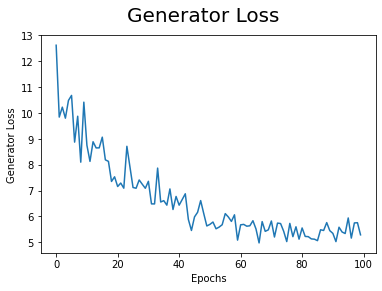

In [188]:
# Generator loss
G_loss_out_file = os.path.join(
    os.path.dirname(os.getcwd()),
    "output",str(exp_index),"viz", "G_loss_plot.jpg")

fig = plt.figure()
plt.plot(G_loss_data.index.tolist(), G_loss_data.iloc[:, 0].values)
fig.suptitle('Generator Loss', fontsize=20)
plt.xlabel('Epochs')
plt.ylabel('Generator Loss')
fig.savefig(G_loss_out_file)

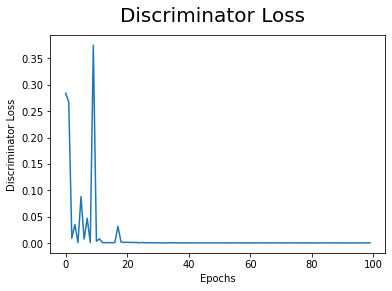

In [192]:
# Discriminator loss
D_loss_out_file = os.path.join(
    os.path.dirname(os.getcwd()),
    "output",str(exp_index),"viz","D_loss_plot.jpg")

fig = plt.figure()
plt.plot(D_loss_data.index.tolist(), D_loss_data.iloc[:, 0].values)
fig.suptitle('Discriminator Loss', fontsize=20)
plt.xlabel('Epochs')
plt.ylabel('Discriminator Loss')
fig.savefig(D_loss_out_file)

# Predict

## Step1

In [360]:
!python functions/cyclegan_transcript.py --eval_dataset_nameA "L1000_MCF7" --ispredicting --exp_index $exp_index --load_model_index 90 --data_version $data_version

{'epoch_resume': 0, 'n_epochs': 100, 'dataset_nameA': 'L1000', 'dataset_nameB': 'ARCHS4', 'batch_size': 100, 'lr': 0.0002, 'b1': 0.9, 'b2': 0.999, 'decay_epoch': 50, 'n_cpu': 8, 'input_dimA': 962, 'hidden_dimA': 512, 'output_dimA': 128, 'input_dimB': 962, 'hidden_dimB': 512, 'output_dimB': 128, 'num_samples': 50000, 'sample_interval': 100, 'checkpoint_interval': 10, 'n_residual_blocks': 1, 'lambda_cyc': 10.0, 'lambda_id': 5.0, 'load_model_index': 100, 'eval_dataset_nameA': 'GTEx', 'eval_dataset_nameB': 'GTEx', 'exp_index': 6, 'ispredicting': False, 'cell_line': None, 'gamma': 0.1, 'shuffle': False, 'data_version': 'v2'}
Namespace(b1=0.9, b2=0.999, batch_size=1, cell_line=None, checkpoint_interval=10, data_version='v2', dataset_nameA='L1000', dataset_nameB='L1000', decay_epoch=100, epoch_resume=0, eval_dataset_nameA='L1000_MCF7', eval_dataset_nameB='GTEx', evaluation=False, exp_index=6, gamma=0.1, hidden_dimA=512, hidden_dimB=512, input_dimA=962, input_dimB=962, ispredicting=True, lambd

In [ ]:
!python functions/cyclegan_transcript.py --eval_dataset_nameA "L1000_MCF7" --eval_dataset_nameB "ARCHS4_MCF7" --ispredicting --exp_index $exp_index --load_model_index 90 --data_version $data_version --evaluation

In [306]:
!python functions/cyclegan_transcript.py --eval_dataset_nameA "GTEx" --eval_dataset_nameB "GTEx" --ispredicting --exp_index $exp_index --load_model_index 90 --data_version $data_version

{'epoch_resume': 0, 'n_epochs': 100, 'dataset_nameA': 'L1000', 'dataset_nameB': 'ARCHS4', 'batch_size': 100, 'lr': 0.0002, 'b1': 0.9, 'b2': 0.999, 'decay_epoch': 50, 'n_cpu': 8, 'input_dimA': 962, 'hidden_dimA': 512, 'output_dimA': 128, 'input_dimB': 962, 'hidden_dimB': 512, 'output_dimB': 128, 'num_samples': 50000, 'sample_interval': 100, 'checkpoint_interval': 10, 'n_residual_blocks': 1, 'lambda_cyc': 10.0, 'lambda_id': 5.0, 'load_model_index': 100, 'eval_dataset_nameA': 'GTEx', 'eval_dataset_nameB': 'GTEx', 'exp_index': 6, 'ispredicting': False, 'cell_line': None, 'gamma': 0.1, 'shuffle': False, 'data_version': 'v2'}
Namespace(b1=0.9, b2=0.999, batch_size=1, cell_line=None, checkpoint_interval=10, data_version='v2', dataset_nameA='L1000', dataset_nameB='L1000', decay_epoch=100, epoch_resume=0, eval_dataset_nameA='GTEx', eval_dataset_nameB='GTEx', exp_index=6, gamma=0.1, hidden_dimA=512, hidden_dimB=512, input_dimA=962, input_dimB=962, ispredicting=True, lambda_cyc=10.0, lambda_id=5.

In [203]:
!python functions/cyclegan_transcript.py --eval_dataset_nameA "GTEx" --eval_dataset_nameB "GTEx" --ispredicting --exp_index $exp_index --load_model_index 90 --data_version $data_version #--shuffle

{'epoch_resume': 0, 'n_epochs': 100, 'dataset_nameA': 'L1000', 'dataset_nameB': 'ARCHS4', 'batch_size': 100, 'lr': 0.0002, 'b1': 0.9, 'b2': 0.999, 'decay_epoch': 50, 'n_cpu': 8, 'input_dim': 962, 'hidden_dim': 512, 'output_dim': 128, 'num_samples': 50000, 'sample_interval': 100, 'checkpoint_interval': 10, 'n_residual_blocks': 1, 'lambda_cyc': 10.0, 'lambda_id': 5.0, 'load_model_index': 100, 'eval_dataset_nameA': 'GTEx', 'eval_dataset_nameB': 'GTEx', 'exp_index': 4, 'ispredicting': False, 'cell_line': None, 'gamma': 0.1, 'shuffle': False, 'data_version': 'v3'}
Namespace(b1=0.9, b2=0.999, batch_size=1, cell_line=None, checkpoint_interval=10, data_version='v3', dataset_nameA='L1000', dataset_nameB='L1000', decay_epoch=100, epoch_resume=0, eval_dataset_nameA='GTEx', eval_dataset_nameB='GTEx', exp_index=4, gamma=0.1, hidden_dimA=512, hidden_dimB=512, input_dimA=962, input_dimB=962, ispredicting=True, lambda_cyc=10.0, lambda_id=5.0, load_model_index=90, lr=0.0002, n_cpu=8, n_epochs=200, n_re

## Step 2

In [361]:
!python functions/extrapolation_transcript.py --eval_input_dataset_name "step1" --eval_output_dataset_name "ARCHS4_MCF7" --ispredicting --exp_index $exp_index --load_model_index 90 

wandb: Currently logged in as: mjjeon (use `wandb login --relogin` to force relogin)
wandb: wandb version 0.10.21 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade
wandb: Tracking run with wandb version 0.10.10
wandb: Syncing run neat-pyramid-28
wandb: ⭐️ View project at https://wandb.ai/mjjeon/L1000toRNAseq_step2
wandb: 🚀 View run at https://wandb.ai/mjjeon/L1000toRNAseq_step2/runs/1ufz3uqn
wandb: Run data is saved locally in /home/maayanlab/Projects/minji/cycleGAN_gene_expression/scripts/wandb/run-20210304_150521-1ufz3uqn
wandb: Run `wandb off` to turn off syncing.

{'epoch_resume': 0, 'n_epochs': 100, 'input_dataset_name': 'ARCHS4_50000_input', 'output_dataset_name': 'ARCHS4_50000_output', 'batch_size': 100, 'lr': 0.0002, 'b1': 0.9, 'b2': 0.999, 'decay_epoch': 50, 'n_cpu': 8, 'input_dim': 962, 'hidden_dim': 512, 'output_dim': 25312, 'num_samples': 50000, 'sample_interval': 100, 'checkpoint_interval': 10, 'load_model_index': 100, 'eval_input_dataset_name': 

In [362]:
# plot results
y_true = pd.read_csv(f"../output_step2/{exp_index}/prediction/y_true.txt", sep="\t", header=None)
y_pred = pd.read_csv(f"../output_step2/{exp_index}/prediction/y_pred.txt", sep="\t", header=None)
# y_input = pd.read_csv(f"../output_step2/{exp_index}/prediction/y_input.txt", sep="\t", header=None)

# shuffled_y_true = pd.read_csv(f"../output/{exp_index}/prediction/shuffle_y_true.txt", sep="\t", header=None)
# shuffled_y_pred = pd.read_csv(f"../output/{exp_index}/prediction/shuffle_y_pred.txt", sep="\t", header=None)




In [363]:
print(y_true.shape)

(202, 25312)


         y_true    y_pred
0      0.499148  0.237450
1      0.077632  0.582089
2      0.146216  0.255033
3      0.091057  0.817273
4      0.181177  0.087234
...         ...       ...
25307  0.000000 -0.026362
25308  0.077632  0.044927
25309  0.000000  0.123468
25310  0.077632 -0.064667
25311  0.232676  0.469630

[25312 rows x 2 columns]


<AxesSubplot:xlabel='y_true', ylabel='y_pred'>

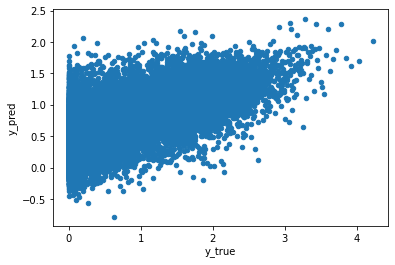

In [364]:
i = 0
tmpdf = pd.DataFrame([y_true.iloc[i, :].tolist(), y_pred.iloc[i, :].tolist()]).T
tmpdf.columns = ["y_true", "y_pred"]
print(tmpdf)
tmpdf.plot.scatter(x='y_true', y='y_pred')

In [150]:
# evaluation
from scipy import stats
from scipy.stats import spearmanr, pearsonr
from sklearn.metrics import r2_score, mean_squared_error, matthews_corrcoef, accuracy_score, roc_auc_score

def get_scores_here(y_true, y_pred):

    scores_dict = dict()

    scores_dict["r2"] = list()
    scores_dict["rmse"] = list()
    scores_dict["pearson"] = list()
    scores_dict["spearmanr"] = list()
    for i in range(len(y_true)):
        tmp_y_true = y_true[i]
        tmp_y_pred = y_pred[i]
        scores_dict["r2"].append(r2_score(tmp_y_true, tmp_y_pred))
        scores_dict["rmse"].append(mean_squared_error(tmp_y_true, tmp_y_pred, squared=False))
        scores_dict["pearson"].append(pearsonr(tmp_y_true, tmp_y_pred)[0])
        scores_dict["spearmanr"].append(spearmanr(tmp_y_true, tmp_y_pred)[0])

    return scores_dict

In [151]:
scores_df = pd.DataFrame(get_scores_here(y_true.values, y_pred.values))
shuffled_scores_df = pd.DataFrame(get_scores_here(shuffled_y_true.values, shuffled_y_pred.values))
input_and_output_scores_df = pd.DataFrame(get_scores_here(y_input.values, y_true.values))

scores_df = pd.concat([scores_df, shuffled_scores_df, input_and_output_scores_df], axis=1)
pearson_df = scores_df["pearson"]
spearman_df = scores_df["spearmanr"]
rmse_df = scores_df["rmse"]

column_names = ["CycleGAN", "Random", "Paired GTEx"]
pearson_df.columns = column_names
spearman_df.columns = column_names
rmse_df.columns = column_names



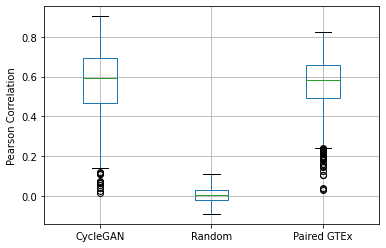

In [152]:
pearson_df.boxplot(column=column_names)
plt.ylabel("Pearson Correlation")
plt.savefig(f"../output/{exp_index}/viz/pearson_corr.png")

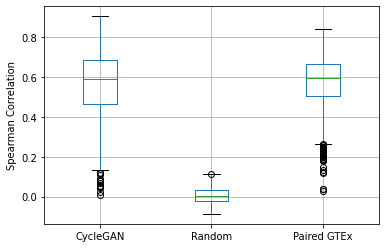

In [153]:
spearman_df.boxplot(column=column_names)
plt.ylabel("Spearman Correlation")
plt.savefig(f"../output/{exp_index}/viz/spearman_corr.png")

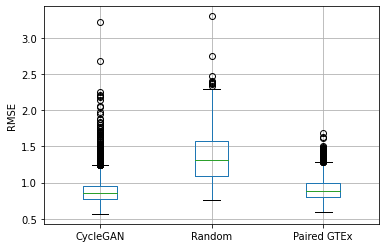

In [154]:
rmse_df.boxplot(column=column_names)
plt.ylabel("RMSE")
plt.savefig(f"../output/{exp_index}/viz/rmse.png")

In [ ]:
y_true.iloc[:10, :5].T.plot.line()

In [ ]:
pearsonr(y_pred.mean(), y_pred.iloc[i, :].values)[0]

In [ ]:
y_pred.iloc[:10, :5].T.plot.line()

In [ ]:
exp_index = 7
num_samples = 50000
cell_line = "MCF7"

%run functions/cyclegan_transcript.py --dataset_nameA "pseudomonas" --dataset_nameB "pseudomonas" --n_epochs 100 --decay_epoch 50 --input_dim 5549 --hidden_dim 1000 --output_dim 128 --num_samples 10000 --batch_size 100 --exp_index $exp_index

In [ ]:
tsne = TSNE(n_components=2)
u = tsne.fit_transform(pd.concat([y_true, y_pred, y_input]))
labels = ["True RNA-seq"]*len(y_true)
labels.extend(["Pred RNA_seq"]*len(y_pred))
# labels.extend(["Input L1000"]*len(y_input))

colors = ["red"]*len(y_true)
colors.extend(["blue"]*len(y_pred))
colors.extend(["yellow"]*len(y_input))
plt.scatter(u[:,0], u[:,1], c=colors)

In [ ]:
fit = umap.UMAP()
u = fit.fit_transform(y_true)
plt.scatter(u[:,0], u[:,1])